# SD-TSIA 211 -  Digit recognition


### BENEDETTI DA ROSA Giovanni and CRISTIAN CHÁVEZ Alejandro

5


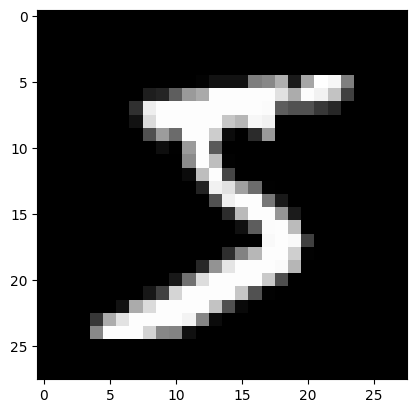

In [65]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from random import *
import matplotlib.pyplot as plt
import pandas as pd

train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1, 784).astype(float) / 255
y_train = train_data[1]
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

## Loadind the Models


In [66]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


# 4 Model
## Question 4.1

How many optimization variables are we going to train using this model?

As input fow the first weights(layers) we have:

$w^{(1)} \in \mathbb{R}^{784 \times 32}$

For the second:
$w^{(2)} \in \mathbb{R}^{ 32 \times 32}$

For the third:
$w^{(3)} \in \mathbb{R}^{ 32 \times 10}$.

In a similar way for the bias vector:
$b^{(1)} \in \mathbb{R}^{32}$, $b^{(2)} \in \mathbb{R}^{32}$, $b^{(3)} \in \mathbb{R}^{10}$

Adding all variables, we will have

784x32 + 32x32 + 32x10 + 32 + 32 + 10

So the total number of variables is 26506


# 5 Stochastic gradient descent


# Question 5.1
Reusing the code provided in the basic functions file, implement stochastic gradient descent
for the resolution of the neural network model.

In [67]:
def update_weights(model, update, gama):
    """
    Update the weights of a model using the given update and learning rate.

    Args:
        model (tf.keras.Model): The model whose weights need to be updated.
        update (list): The update values for each weight in the model.
        gama (float): The learning rate or step size for the weight update.

    Returns:
        None
    """
    # Create a copy of the model's current weights
    new_weights = model.trainable_weights.copy()

    # Update each weight using the update and learning rate
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] - (gama * update[i])

    # Set the updated weights back to the model
    model.set_weights(new_weights)

In [68]:

def stochastic_gradient_descent(model, x_train, y_train, loss, epochs, gamma_initial):
	"""
	Performs stochastic gradient descent optimization on a given model.

	Parameters:
	- model: The model to be optimized.
	- x_train: The input training data.
	- y_train: The target training data.
	- loss: The loss function used to calculate the loss value.
	- epochs: The number of epochs to train the model.
	- gamma_initial: The initial learning rate.

	Returns:
	- values_to_show: A list of loss values at every 500 epochs.
	"""
	# array to save our information
	values_to_show = []
	
	# updating our learning rate
	gamma = 1 / (np.sqrt(epochs) * 2)
	
	for epoch in range(epochs):
		if (epoch % 500 == 0):
			# Compute the loss value at every 500 epochs
			logits = model(x_train)
			loss_value = loss(y_train, logits)
			values_to_show.append(loss_value)
		
		# choosing a random point
		e = randint(0, epochs)  # picking a random position for our 1-batch sgd
		x_train_batch = x_train[e].reshape(-1, 784)
		y_train_batch = y_train[e]
		
		with tf.GradientTape() as tape:
			logits = model(x_train_batch)
			loss_value = loss(y_train_batch, logits)
		
		grad = tape.gradient(loss_value, model.trainable_weights)
		update_weights(model, grad, gamma)
	
	return values_to_show

## Question 5.2
Run it for one pass over the data (also called one epoch) and with a learning rate that
satisfies the conditions required by theory. Plot the objective value as a function of the iterations.
Hint: Do not compute the objective value at each iteration, only from time to time. Thisis sufficient for plotting purposes and will save computing time.

As we know the number of iterations K we are going to perform, we can set a constant step size $\gamma_k = \frac{a}{\sqrt{K}}$, where $a = \frac{1}{2}$.

Remark 4.3.1 of the poly.



120


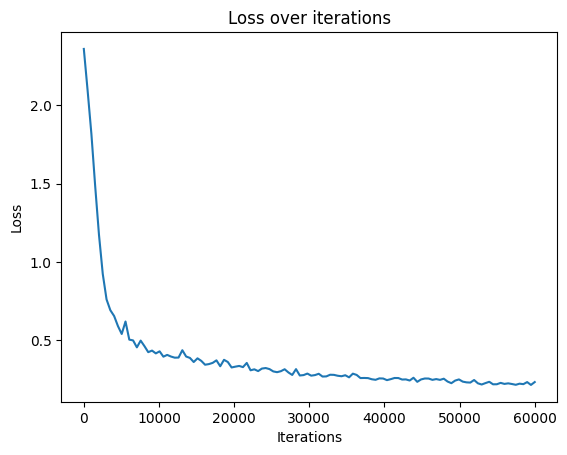

In [69]:
iterations = 60000
lossValues = stochastic_gradient_descent(model, x_train, y_train, loss, iterations, 1)
print(len(lossValues))
x = np.linspace(0,iterations,len(lossValues))
plt.plot(x, lossValues)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()

# 6. Empirical risk minimization

## Question 6.1 

Implement stochastic gradient descent for the resolution of the empirical risk minimization problem and run it for 10 epochs.
Sometimes practicioners select several samples at each iteration (this is called a batch of samples) and they average them. This results in the algorithm:


$$x_{k+1} = x_{k} - \gamma_{k} \frac{1}{|b_{k+1}|} \sum_{i \in b_{k+1}} \nabla f(x_{k}, i)$$


In [70]:

def empirical_risk_minimization(model, x_train, y_train, loss, epochs, batch, iterations, gamma):
      """
      Perform empirical risk minimization using stochastic gradient descent.

      Args:
            model (tf.keras.Model): The model to train.
            x_train (numpy.ndarray): The input training data.
            y_train (numpy.ndarray): The target training data.
            loss (tf.keras.losses.Loss): The loss function to minimize.
            epochs (int): The number of epochs to train for.
            batch (int): The batch size for each iteration.
            iterations (int): The total number of iterations.
            gamma (float): The learning rate.

      Returns:
            tuple: A tuple containing the list of loss values and the list of true values predicted by the model.
      """
      

      values_to_show = []
      true_values = []  # Store the true values predicted by the model

      for j in range(epochs):
            for i in range(iterations // batch):
                  if (iterations % 500 == 0):
                        logits = model(x_train)
                        loss_value = loss(y_train, logits)
                        values_to_show.append(loss_value)

                  random_data = np.random.randint(0, int(iterations // batch))
                  x_train_batch = x_train[random_data * batch:(random_data + 1) * batch].reshape(-1, 784)
                  y_train_batch = y_train[random_data * batch:(random_data + 1) * batch]

                  with tf.GradientTape() as tape:
                        logits = model(x_train_batch)
                        loss_value = loss(y_train_batch, logits)

                  grad = tape.gradient(loss_value, model.trainable_weights)
                  update_weights(model, grad, gamma)

                  # Compute the true values predicted by the model
                  true_values_batch = model.predict(x_train_batch)
                  true_values.extend(true_values_batch)

      return values_to_show, true_values



2/2 [==============================] - 0s 3ms/step


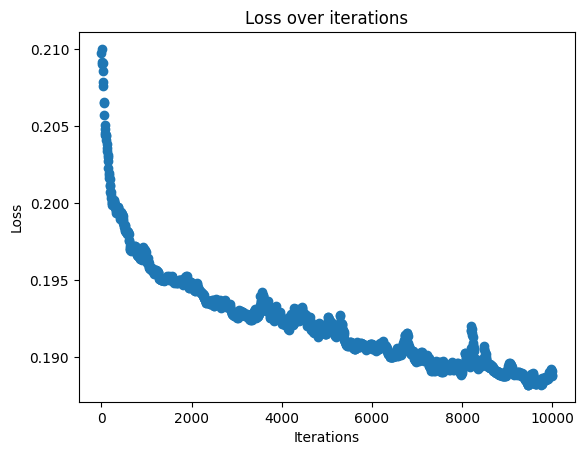

In [71]:
# Example usage:
batch_size = 64
epochs = 10
iterations = 10000
gamma = 1/(2*np.sqrt(iterations))

objective_values, true_values = empirical_risk_minimization(model, x_train, y_train, loss, epochs, batch_size, iterations, gamma)
x = np.linspace(0,iterations,len(objective_values))
plt.scatter(x, objective_values)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()


## Question 6.2
According to you, what is the advantage of such a scheme?

The advatage is that utilizing a batch approach offers the benefit of enhanced computational efficiency and potentially improved convergence characteristics. Processing multiple samples simultaneously allows us to leverage vectorized operations supported by libraries such as TensorFlow, resulting in accelerated computations through parallelism. Furthermore, employing batches aids in stabilizing the learning process by furnishing more consistent gradients, thereby promoting smoother convergence and enhanced generalization.


## Question 6.3
Add the option of the batch size to your algorithm.
To add the option of batch size to the algorithm, you can modify the function parameters to include a batch_size parameter.
Then, we can adjust the loop to iterate over batches instead of individual samples. The function provided above already incorporates this feature with the batch_size parameter.

```python
def empirical_risk_minimization(model, x_train, y_train, loss, epochs, batch, iterations):

# 7 Evaluating the model

## Question 7.1 
Evaluate the accuracy of the model on the training set and on the test set.

In [72]:

# Function to evaluate the performance of a given model on the provided inputs and targets
def evaluate(model, inputs, targets):
    """
    Evaluates the performance of a given model on the provided inputs and targets.

    Parameters:
    model (object): The model to be evaluated.
    inputs (numpy.ndarray): The input data for evaluation.
    targets (numpy.ndarray): The target data for evaluation.

    Returns:
    tuple: A tuple containing the loss value and accuracy value of the evaluation.
    """
    # Randomly sample 1000 indices from the inputs
    sampled_indices = np.random.randint(0, len(inputs), 1000)
    
    # Get predictions from the model for the sampled inputs
    predictions = model(inputs[sampled_indices])
    
    # Calculate the loss value using the loss function and the sampled targets
    loss_value = loss(targets[sampled_indices], predictions).numpy()
    
    # Calculate the accuracy value by comparing the predicted labels with the sampled targets
    accuracy_value = np.mean(np.argmax(predictions, axis=1) == targets[sampled_indices])
    
    # Return the loss value and accuracy value
    return loss_value, accuracy_value


# Test data
x_test = test_data[0].reshape(-1, 784).astype(float) / 255
y_test = test_data[1]

# Evaluation of the model on train and test sets
# Evaluate the model on the training set
eval_train, train_accuracy = evaluate(model, x_train, y_train)

# Evaluate the model on the test set
eval_test, test_accuracy = evaluate(model, x_test, y_test)

# Create a dataframe to display the evaluation results
data = {'Set': ['Train', 'Test'], 'Loss': [eval_train, eval_test],  'accuracy': [train_accuracy, test_accuracy]}
df = pd.DataFrame(data)

# Print the dataframe
print(df)

     Set      Loss  accuracy
0  Train  0.204693     0.946
1   Test  0.201762     0.937
